In [38]:
N_INLIER = 800
N_OUTLIER_CLUSTERED = 300
N_OUTLIER_SCATTER = 300
ROTATION_ANGLE = 30  # [deg]
SEED = 123

# Generate Toy data

In [39]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)

In [40]:
import numpy as np
from typing import Tuple, Optional


def generate_toy_data(
    num_inliers=100,
    sigma_inlier=0.3,
    cylinder_height=5.0,
    rotation_angle=-30,
    num_outlier_clustered=30,
    loc_outlier_clustered=(2.5, 4.0),
    sigma_outlier_clustered=0.03,
    num_outlier_scatter=50,
    range_outlier_scatter=(-5.0, 5.0),
    seed=123,
):
    np.random.seed(seed)
    x = np.random.normal(loc=0, scale=sigma_inlier, size=num_inliers)
    y = np.random.uniform(low=-cylinder_height / 2.0, high=cylinder_height / 2.0, size=num_inliers).reshape(-1, 1)
    cylindal_point_2d = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

    st = np.sin(np.deg2rad(rotation_angle))
    ct = np.cos(np.deg2rad(rotation_angle))
    rotation_dcm = np.array([[ct, -st], [st, ct]])

    X = cylindal_point_2d.dot(rotation_dcm.T).reshape(-1, 2)
    X_noise_clustered = np.random.multivariate_normal(
        mean=loc_outlier_clustered, cov=np.diag([sigma_outlier_clustered, sigma_outlier_clustered]), size=num_outlier_clustered
    )
    X_noise_scattered = np.random.uniform(low=range_outlier_scatter[0], high=range_outlier_scatter[1], size=num_outlier_scatter).reshape(-1, 2)

    X = np.vstack([X, X_noise_clustered, X_noise_scattered])
    return X


def draw_scatter_points(X, line_end_points: Optional[Tuple[float, float, float, float]] = None, rect_size=5.0):
    plt.scatter(X[:, 0], X[:, 1])
    plt.xlim(-rect_size, rect_size)
    plt.ylim(-rect_size, rect_size)
    if line_end_points is not None:
        for ep_tuple in line_end_points:
            p1 = (ep_tuple[0], ep_tuple[1])
            p2 = (ep_tuple[2], ep_tuple[3])
            plt.axline(p1, p2, color="red")
    plt.show()


def generate_line_end_points_from_parameteres(line_direction, line_center, p1_end_x, p2_end_x):
    """n_x (x - cx) + n_y (y - cy) = 0
    y = - n_x / n_y (x - cx) + c_y
    """
    line_normal = np.array([-line_direction[1], line_direction[0]])
    print("normal", line_normal)
    p1_end_y = -line_normal[0] / line_normal[1] * (p1_end_x - line_center[0]) + line_center[1]
    p2_end_y = -line_normal[0] / line_normal[1] * (p2_end_x - line_center[0]) + line_center[1]
    return (p1_end_x, p1_end_y, p2_end_x, p2_end_y)


def draw_pca_results(X, principal_components, mu):
    line_direction = principal_components[:, 0]
    line_center = mu
    line_endpoint_tuple = generate_line_end_points_from_parameteres(line_direction, line_center, p1_end_x=-2.0, p2_end_x=2.0)
    draw_scatter_points(X, [line_endpoint_tuple])


In [41]:
X_naive = generate_toy_data(num_inliers=N_INLIER, num_outlier_clustered=0, num_outlier_scatter=0, rotation_angle=ROTATION_ANGLE, seed=SEED)
X_noisy = generate_toy_data(num_inliers=N_INLIER, num_outlier_clustered=N_OUTLIER_CLUSTERED, num_outlier_scatter=N_OUTLIER_SCATTER, rotation_angle=ROTATION_ANGLE, seed=SEED)

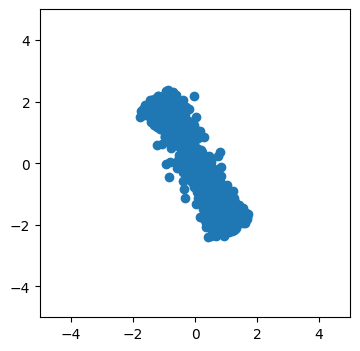

In [42]:
draw_scatter_points(X_naive)

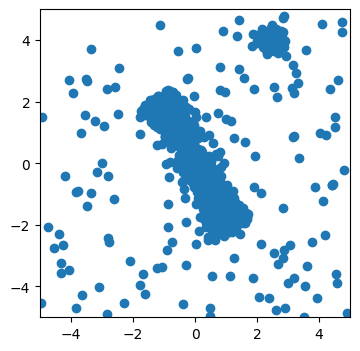

In [43]:
draw_scatter_points(X_noisy)

# Define naive PCA function

In [44]:
def PCAFitting(X):
    mu = np.mean(X, axis=0)
    S = np.cov(X.T)
    print(S)
    scores, principal_components = np.linalg.eigh(S)
    arg_order = np.argsort(scores)[::-1]  # descent-order
    scores = scores[arg_order]
    principal_components = principal_components[:, arg_order]
    return scores, principal_components, mu

[[ 0.64133626 -0.95346582]
 [-0.95346582  1.74637836]]
[2.29584487 0.09186975]
[[-0.49930656 -0.86642539]
 [ 0.86642539 -0.49930656]]
normal [-0.86642539 -0.49930656]


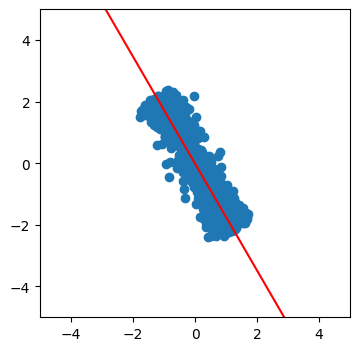

In [45]:
scores, principal_components, mu = PCAFitting(X_naive)
print(scores)
print(principal_components)

draw_pca_results(X_naive, principal_components, mu)

#print(np.cov(X_naive.T))
#print((principal_components).dot(np.diag(scores)).dot(principal_components.T))

In [46]:
print(principal_components)

[[-0.49930656 -0.86642539]
 [ 0.86642539 -0.49930656]]


[[2.48075269 1.29120151]
 [1.29120151 5.18496383]]
normal [-0.92822605  0.37201668]


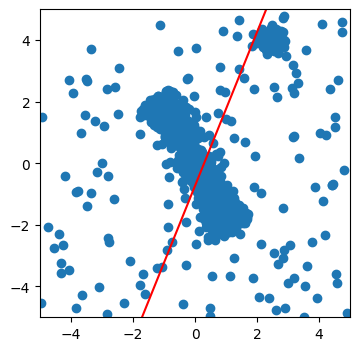

In [47]:
scores, principal_components, mu = PCAFitting(X_noisy)
draw_pca_results(X_noisy, principal_components, mu)

In [48]:
from pyod.models.mcd import MCD


def RobustPCAFittingFastMCD(X, seed=123):
    fmcd = MCD(random_state=np.random.RandomState(seed))
    fmcd.fit(X)
    scores, principal_components = np.linalg.eigh(fmcd.covariance_)
    arg_order = np.argsort(scores)[::-1]  # descent-order
    scores = scores[arg_order]
    principal_components = principal_components[:, arg_order]
    return scores, principal_components, fmcd.location_


normal [-0.86460986 -0.50244383]


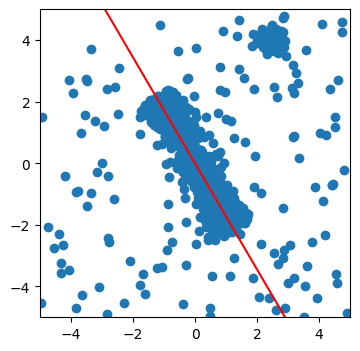

In [49]:
scores, principal_components, mu = RobustPCAFittingFastMCD(X_noisy)
draw_pca_results(X_noisy, principal_components, mu)

[5.70245469 1.96326183] 
 [[-0.37201668 -0.92822605]
 [-0.92822605  0.37201668]]
normal [ 0.92822605 -0.37201668]


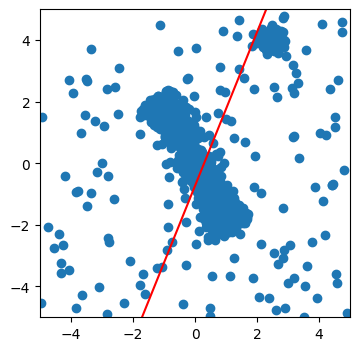

In [50]:
from PyRobustPCA import VanillaPCA

pca = VanillaPCA()
pca.fit(X_noisy)
centre = pca.get_mean()
scores = pca.get_scores()
pcs = pca.get_principal_components()
indices_ascending = np.argsort(scores)[::-1]
scores = scores[indices_ascending]
pcs = pcs[:, indices_ascending]
print(scores, "\n", pcs)

draw_pca_results(X_noisy, pcs, centre)

0.0029141902923583984
[2.37767622 0.17293366] 
 [[ 0.47242613 -0.88137027]
 [-0.88137027 -0.47242613]]
normal [0.88137027 0.47242613]


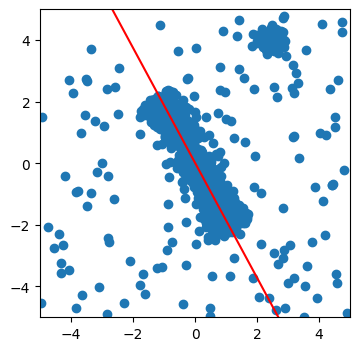

In [51]:
import time
from PyRobustPCA import RobustPCAOGK

start = time.time()
pca = RobustPCAOGK()
pca.fit(X_noisy)
centre = pca.get_mean()
scores = pca.get_scores()
pcs = pca.get_principal_components()
end = time.time()
print(end-start)
indices_ascending = np.argsort(scores)[::-1]
scores = scores[indices_ascending]
pcs = pcs[:, indices_ascending]
print(scores, "\n", pcs)

draw_pca_results(X_noisy, pcs, centre)

0.006423473358154297
[1.43992311 0.16764896] 
 [[ 0.44477973 -0.89563999]
 [-0.89563999 -0.44477973]]
normal [0.89563999 0.44477973]


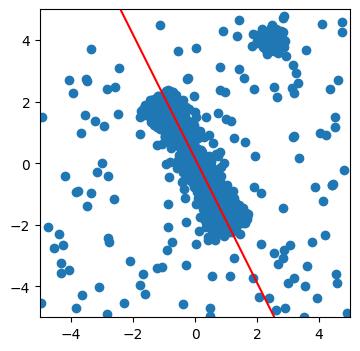

In [53]:
import time
from PyRobustPCA import RobustPCADetMCD

start = time.time()
pca = RobustPCADetMCD()
pca.fit(X_noisy, n_iter=2)
centre = pca.get_mean()
scores = pca.get_scores()
pcs = pca.get_principal_components()
end = time.time()
print(end-start)
indices_ascending = np.argsort(scores)[::-1]
scores = scores[indices_ascending]
pcs = pcs[:, indices_ascending]
print(scores, "\n", pcs)

draw_pca_results(X_noisy, pcs, centre)